In [15]:
import pandas as pd
from datetime import datetime, timedelta
import datetime as dt

In [16]:
from IPython.display import Image

In [17]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [18]:
brands=pd.read_csv('brands.csv')
users=pd.read_csv('users.csv')
cpg=pd.read_csv('cpg.csv')
receipts=pd.read_csv('receipts.csv')
rewardItems=pd.read_csv('rewardReceiptItems.csv')

# Task 3: Evaluate Data Quality Issues in the Data Provided
Using the programming language of your choice identify at least **one data quality issue**. We are not expecting a full blown review of all the data provided, but instead want to know how you explore and evaluate data of questionable provenance.

## 1. Missing Values and Duplicates

In [19]:
tables=[('brands', brands), ('users', users), ('cpg', cpg), ('receipts', receipts), ('rewardItems', rewardItems)]
for table_name, table in tables:
    print(table_name)
    print(table.shape)
    print(table.isna().sum())
    print("Total null values in " + table_name + ": " + str(table.isna().sum().sum()))
    print()

brands
(1167, 7)
id                0
name              0
category        155
categoryCode    650
barcode           0
brandCode       269
topBrand        612
dtype: int64
Total null values in brands: 1686

users
(212, 7)
id               0
active           0
createdDate      0
lastLogin       40
role             0
signUpSource     5
state            6
dtype: int64
Total null values in users: 51

cpg
(1167, 3)
id        0
cpgRef    0
cpgId     0
dtype: int64
Total null values in cpg: 0

receipts
(1119, 12)
id                           0
userId                       0
bonusPointsEarned          575
bonusPointsEarnedReason    575
createDate                   0
dateScanned                  0
modifyDate                   0
pointsEarned               510
purchaseDate               448
purchasedItemCount         484
rewardsReceiptStatus         0
totalSpent                 435
dtype: int64
Total null values in receipts: 3027

rewardItems
(6941, 35)
id                                       0
ba

We have signicant number of null values, especially in rewardItems table with over 150,000 null values. This can lead to incorrect inferences and loss of information. 

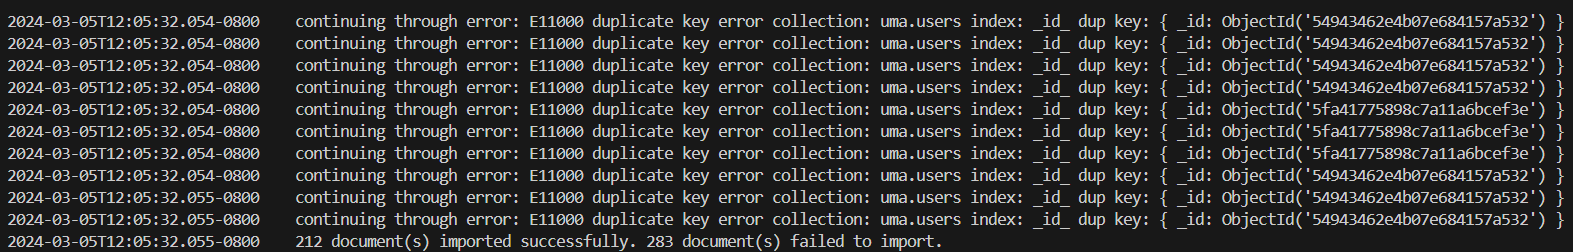

In [20]:
image_path = 'user_duplicates.png'

# Display the image
Image(filename=image_path)

## 2. Data Integrity Issues

In [21]:
#1
receipts[receipts['rewardsReceiptStatus']== 'REJECTED'][['rewardsReceiptStatus','pointsEarned']]

,rewardsReceiptStatus,pointsEarned
4,REJECTED,5.0
10,REJECTED,750.0
28,REJECTED,NaN
59,REJECTED,750.0
168,REJECTED,NaN
...,...,...
1108,REJECTED,25.0
1112,REJECTED,25.0
1115,REJECTED,25.0
1117,REJECTED,25.0


It appears that receipts marked as 'REJECTED' have earned points in some cases. This is inconsistent with the expected behavior, as rejected receipts should not be eligible for points.

To address this issue, it is important to investigate the root cause. This could involve reviewing the data entry process, the logic used to assign points, and any system errors that may have occurred.

In [22]:
#2
rewardItems.shape
rewardItems['targetPrice'].value_counts()

(6941, 35)

800.0    299
77.0      79
Name: targetPrice, dtype: int64

In [29]:
#3

I found 2 different instances in which incorrect/incomplete data entry will hinder further analysis
Presence of "ITEM NOT FOUND" in rewardItems.description and "test brand" in brands.name and brands.brandCode makes it challenging to perform meaningful analysis.

In [23]:
rewardItems.description.value_counts()

ITEM NOT FOUND                                                         173
KLARBRUNN 12PK 12 FL OZ                                                120
HUGGIES SIMPLY CLEAN PREMOISTENED WIPE FRAGRANCE FREE BAG 216 COUNT     92
MILLER LITE 24 PACK 12OZ CAN                                            90
KLEENEX POP UP RECTANGLE BOX FACIAL TISSUE 2 PLY 8PK 160 CT             87
                                                                      ... 
315 LUCMILK1 N A                                                         1
314 LUC CHESEME ICAN                                                     1
312 LUC CHESE MED CHED                                                   1
311 LUC EGGS LARGE AA                                                    1
Zucchini                                                                 1
Name: description, Length: 1889, dtype: int64

In [24]:
(brands['name'].str.lower().str.contains("test brand")).sum()
(brands['brandCode'].str.lower().str.contains("test brand")).sum()

429

358

In [25]:
test_rows = brands[(brands['name'].str.lower().str.contains("test brand")) | (brands['brandCode'].str.lower().str.contains("test brand"))]

In [26]:
test_rows.head()

,id,name,category,categoryCode,barcode,brandCode,topBrand
0,601ac115be37ce2ead437551,test brand @1612366101024,Baking,BAKING,511111019862,NaN,False
5,5f4bf556be37ce0b4491554d,test brand @1598813526777,Baking,BAKING,511111516354,TEST BRANDCODE @1598813526777,NaN
9,601ac142be37ce2ead43755a,test brand @1612366146051,Baking,BAKING,511111519874,TEST BRANDCODE @1612366146051,False
13,601ac142be37ce2ead43755e,test brand @1612366146827,Candy & Sweets,CANDY_AND_SWEETS,511111319917,TEST BRANDCODE @1612366146827,False
14,601ac142be37ce2ead43755d,test brand @1612366146176,Baking,BAKING,511111819905,TEST BRANDCODE @1612366146176,False


- From receipt.json file, I created 2 tables - receipts which contains information about 'totalSpent' and rewardReceiptItems which has columns for 'finalPrice','itemPrice', 'quantityPurchased'. 
- Ideally totalSpent for a receipt should be equal sum(quantityPurchased * finalPrice) of all the items purchased in the receipt but thats not the case here - indicating data error

In [27]:
check_spend = pd.merge(rewardItems, receipts, right_on='id', left_on='id', how="inner")
#Ideally totalSpent should be equaly to sum(finalPrice * quantityPurchased) - for all receipts with same receipt id 
check_spend[['id','totalSpent', 'finalPrice','itemPrice', 'quantityPurchased']].head()

,id,totalSpent,finalPrice,itemPrice,quantityPurchased
0,5ff1e1eb0a720f0523000575,26.0,26.0,26.0,5.0
1,5ff1e1ee0a7214ada100056f,28.0,28.0,28.0,4.0
2,5ff1e1ed0a7214ada100056e,20.0,20.0,20.0,5.0
3,5ff1e1bb0a720f052300056b,11.0,1.0,1.0,1.0
4,5ff1e1bb0a720f052300056b,11.0,10.0,10.0,1.0


In [28]:
receipts['rewardsReceiptStatus'].unique()

array(['FINISHED', 'REJECTED', 'FLAGGED', 'SUBMITTED', 'PENDING'],
      dtype=object)

- Also here, we do not have a value that explicitly suggests that a receipt was processed successfully. It could be that "FINISHED" is intended to serve this purpose - but finished has some ambiguity around it - was it finished successfully? Was it with errors?